# Capstone Project

Congratulations on reaching the end of the deep learning module. I believe this week has been pretty hard with a lot of new information. So now you will get a chance to put in practice all the pieces of material you learned and see how it all fits together. 
As with the previous capstone projects, the outcome of this module should potentially serve as your portfolio item, so put effort into making it a quality piece of work.

## Background

<div style="text-align:center;margin-top:10px">
<div><img style="width:400px" src="https://th.thgim.com/news/national/6rs0yd/article26627480.ece/ALTERNATES/FREE_660/IMG-fakenews"></img><div>
<div style="margin: -30px 0 20px 0; color:rgb(117, 117, 117);font-size:12px;">Source: https://www.facebook.com/STFUIndianMedia/</div>
</div>

One of the biggest worldwide challenges we are facing these days is misinformation. Incorrect information can be harmless in some contexts, but can be devastating in others https://30secondes.org/en/module/impacts-of-fake-news/

<div style="margin:2% 15%;color:#757575;font-size:30px;text-align:center;font-weight:400px">"It is now known that false information played a major role in the last American presidential election"
    <div style="margin-bottom:20px; color:rgb(117, 117, 117);font-size:12px;">Source: https://30secondes.org/en/module/impacts-of-fake-news/</div>
</div>



So, for this project, we are going to classify fake information. More specifically, this is an NLP problem, we will use article headlines and body text and will try to guess whether a particular article is fake or not.

We will use https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset dataset from Kaggle.

---

## Requirements

#### General requirements for projects are as follow:

- Do EDA
- Try to find most predictive features from your data and use heuristic rules as your baseline
- Make 2+ ML models (LogReg, RandomForest, NaiveBayes, BootsedTrees, ...) with engineered features.
- Make an end-to-end trainable deep-learning model
- You should use Pytorch, PyTorch Lightning or FastAI for the DL implementation.
- Clearly describe your thought process and reasoning in the notebook.
- Compare performances of all models. Which one is the best? Why?
- Analyze the misclassified items, understand and present why are they harder for the model to guess.

#### Presentation
Make a presentation about the project: 
- Describe your work (data, model, results)
- Identify biggest challenges
- Suggest areas for improvement of you approach


## Evaluation Criteria

- Demonstration of your deep learning skills
- Demonstration of ML engineering skills 
- Aggregate model performance
- Code quality
- Delivery of the presentation

## Bonus challenges

- Study your model with model interpretability tools, like Lime

In [ ]:
!pip install pytorch-lightning neptune-client emoji transformers lime catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import time
import tqdm
import emoji
import string
import spacy
import re
import nltk
from nltk.tokenize import word_tokenize
import warnings
warnings.filterwarnings('ignore')

import transformers
import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, roc_auc_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer

from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from keras.preprocessing import sequence

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# EDA

First thing is to look in to what kind of data do we have. There are two datasets: real and fake news. Both of them consist of article title, article text, subject and date of publication. I will load both of these datasets and append additional column to them, indicating whether they are real or fake. The column ['fake'] will have value 0 if article is real and 1 if article is fake. Additionally, I will concatenate these datasets into one, shuffle and reindex it. 

In [71]:
fake_news = pd.read_csv("/content/drive/MyDrive/44/Fake.csv")
fake_news['fake'] = 1

true_news = pd.read_csv("/content/drive/MyDrive/44/True.csv")
true_news['fake'] = 0

news = pd.concat([fake_news, true_news])
news = news.sample(frac = 1).reset_index(drop=True)
news.head()

,title,text,subject,date,fake
0,This Moving Message To Trump Supporters Might...,What started as a prank to annoy Trump support...,News,"April 12, 2016",1
1,Thousands of Saakashvili supporters stage prot...,KIEV (Reuters) - Several thousand people march...,worldnews,"December 10, 2017",0
2,Trump Jr. Once Again Shows His Lack Of Humani...,We ve all seen the horrific photos of children...,News,"September 20, 2016",1
3,COMEDIAN SHOCKS LEFTIST COLLEGE STUDENTS With ...,This video of conservative comedian Steven Cro...,politics,"Apr 26, 2016",1
4,COMRADES IN LIBERAL MI College Town Filled Wit...,University of Michigan is located in Ann Arbor...,politics,"Aug 24, 2016",1


In [5]:
news.isna().sum()

title      0
text       0
subject    0
date       0
fake       0
dtype: int64

Dataset contains no NaN values, however, there might be some duplicates. I will check for duplicates according to the title and text and remove them.

In [6]:
len(news[(news.duplicated(subset=['title'])) | (news.duplicated(subset=['text']))]), len(news)

(6628, 44898)

In [7]:
news = news.drop_duplicates(subset='title').drop_duplicates(subset='text')
len(news)

38270

Before duplicate removal dataset had 44898 rows, 6628 of which were duplicates. After removal I am left with 38270 unique articles. Next step is to do some EDA. For this purpose I will create two new columns: one will have number of words in title and other - number of words in raw article text. Then I will plot news, title and text length distributions.

In [8]:
news['title_words'] = news['title'].apply(lambda x: len(x.split()))
news['text_words'] = news['text'].apply(lambda x: len(x.split()))

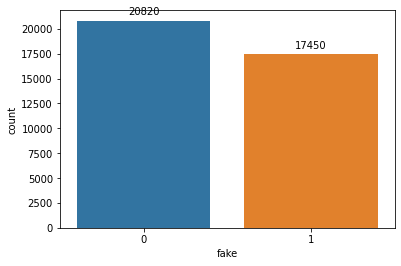

In [9]:
def autolabel(bar_plot):
    """
    Attach a text label above each bar displaying its height
    """
    for p in bar_plot.patches:
        bar_plot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')
        
autolabel(sns.countplot(x="fake", data=news))

Dataset contains of 20820 real and 17450 fake news.

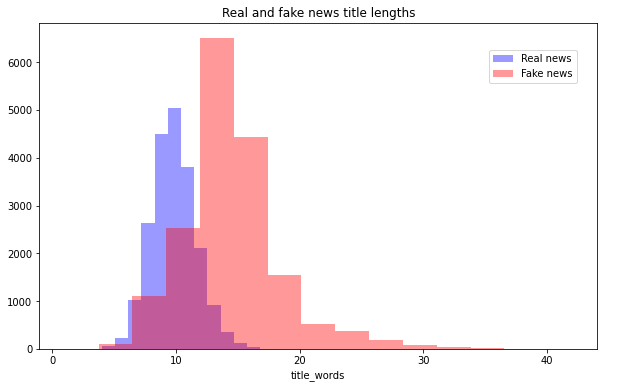

In [10]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(news[news['fake']==0]['title_words'],bins=15, kde=False, color='blue')
ax = sns.distplot(news[news['fake']==1]['title_words'],bins=15, kde=False, color='red')
ax.set_title("Real and fake news title lengths")
fig.legend(labels=['Real news','Fake news'], loc='upper right', ncol=1, borderaxespad=5)
plt.show()

As seen from the picture above, fake news articles tend to have longer titles. This could be a good assumption for heuristic model. 

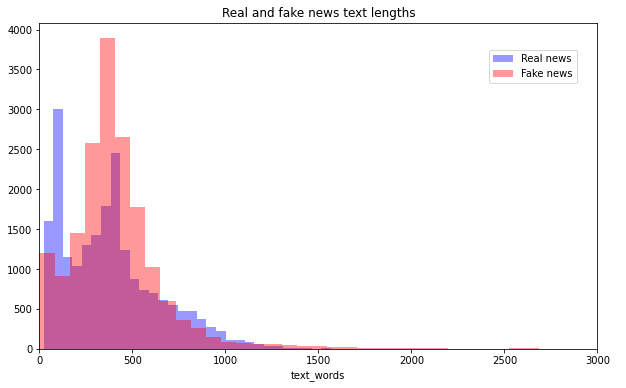

In [11]:
fig = plt.figure(figsize=(10,6))
ax = sns.distplot(news[news['fake']==0]['text_words'],bins=100, kde=False, color='blue')
ax = sns.distplot(news[news['fake']==1]['text_words'],bins=100, kde=False, color='red')
ax.set_xlim(0, 3000)
ax.set_title("Real and fake news text lengths")
fig.legend(labels=['Real news','Fake news'], loc='upper right', ncol=1, borderaxespad=5)
plt.show()

Although the main distribution of real and fake news lengths looks similar, fake news also have a tendency to be very long - some even reaching 2600-2700 words.

In [12]:
news['text'] = news['title'] + news['text']

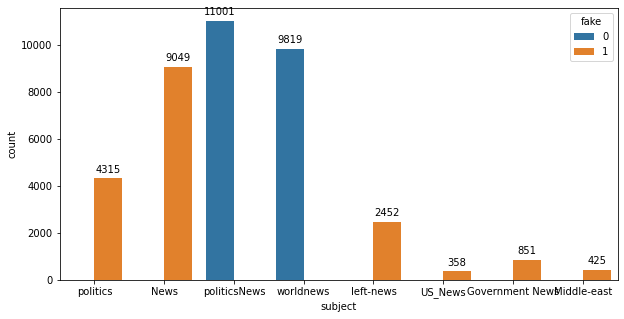

In [13]:
ax = plt.figure(figsize=(10,5))
ax = sns.countplot(x='subject', data=news, hue='fake')
autolabel(ax)

After counting articles by subject we can see that rows with politicsNews and worldnews in subject column are real news, everything else - false. This could also be a good assumption for heuristic model, but unfortunately such subject names are no basis to decide the validity of an article.

In [14]:
news['date'] = pd.to_datetime(news['date'], errors='coerce')
news['Year'] = news['date'].dt.year
news['Month'] = news['date'].dt.month

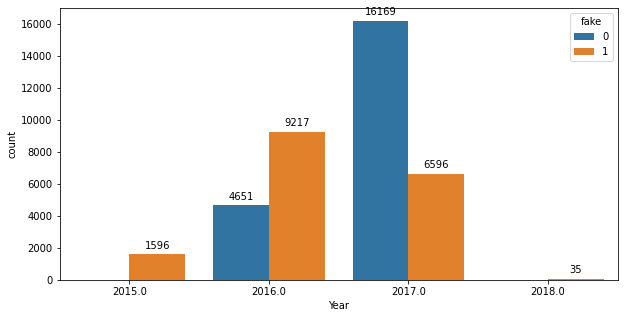

In [15]:
ax = plt.figure(figsize=(10,5))
ax = sns.countplot(x='Year', data=news, hue='fake')
autolabel(ax)

Article distribution by year shows us that real articles are collected from 2016-2017 - these were the years of the upcoming elections in the USA. News from 2015 are only fake while 2016 has double the number of fakes than reals. 2017 contains almost 2.5 times more real articles than fake.

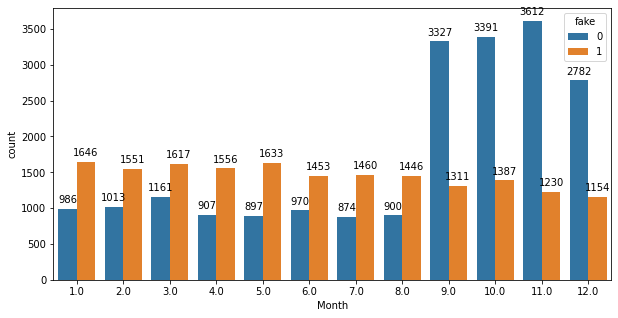

In [16]:
ax = plt.figure(figsize=(10,5))
ax = sns.countplot(x='Month', data=news, hue='fake')
autolabel(ax)

Although there is significant increase in articles towards autumn and winter, fake news were coming along kind of equally throughout all months.

# Heuristic model

First thing to try is the heuristic model - a set of simple rules to see if there are any distinctive features that could help us to classify our news. Let's take a look at several examples from real news.

In [72]:
news.text[news['fake']==0]

1        KIEV (Reuters) - Several thousand people march...
5        (Reuters) - A U.S. appeals court on Wednesday ...
7        BEIRUT (Reuters) - Lebanon s foreign minister ...
9        PARIS (Reuters) - With U.S. President Donald T...
10       WASHINGTON (Reuters) - President Donald Trump ...
                               ...                        
44891    WASHINGTON (Reuters) - U.S. President Donald T...
44892    NEW YORK (Reuters) - Democrat Hillary Clinton’...
44893    WASHINGTON (Reuters) - The White House said on...
44894    (Reuters) - Democrat Doug Jones’ surprise vict...
44897    NEW YORK (Reuters) - Republican presidential c...
Name: text, Length: 21417, dtype: object

Didn't need to look far. All of the examples above contain word 'reuters', which is news agency company with HQ in London. Seems that the creators of this dataset took real news only from one source. Let's check if this single word can be a base for our heuristic model. 

In [18]:
news[news.text.str.contains('reuters', case=False)]['fake'].value_counts()

0    20786
1      220
Name: fake, dtype: int64

Almost all real news contain word 'reuters'! Let's create a simple rule: if text has word 'reuters' in it, we will classify it as real news and if it doesn't - then it will be fake news. 

In [19]:
def heuristic_classifier(text: str) -> int:
    "Return 0 for real, 1 for fake"
    return 0 if 'reuters' in str(text).lower() else 1

In [20]:
X_heur, y_heur = news['text'], news['fake']
X_train_heur, X_test_heur, y_train_heur, y_test_heur = train_test_split(X_heur, y_heur, test_size=0.2, random_state=42)

print(len(X_train_heur), len(X_test_heur), len(y_train_heur), len(y_test_heur))

30616 7654 30616 7654


In [21]:
X_test_heur = pd.DataFrame(X_test_heur)

In [22]:
start = time.time()
heuristic_preds = [heuristic_classifier(text) for text in X_test_heur['text']]
end = time.time()

In [23]:
heur_score = accuracy_score(y_test_heur, heuristic_preds)
heur_roc = roc_auc_score(y_test_heur, heuristic_preds)
heur_inference = np.round(32*(end-start)/len(X_test_heur),4)
print("The accuracy of heuristic model is: %0.2f" %heur_score)
print("The roc_auc score of heuristic model is: %0.2f" %heur_roc)
print(f"Inference time for a batch of 32 entries is: {heur_inference}s")

The accuracy of heuristic model is: 0.99
The roc_auc score of heuristic model is: 0.99
Inference time for a batch of 32 entries is: 0.0005s


In [24]:
print(classification_report(y_test_heur, heuristic_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4166
           1       1.00      0.99      0.99      3488

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



Text(0.5, 1.0, 'Confusion matrix for fake news classification of heuristic model')

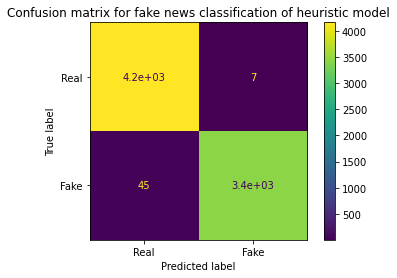

In [25]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test_heur, heuristic_preds), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of heuristic model")

In [26]:
heur_report = pd.DataFrame({"Model": ["Heuristic"],
                          "Accuracy": [heur_score],
                          "ROC": [heur_roc],
                          "Inference (s)": [heur_inference]})

Classification results do not surprise - almost perfect f1 score for our heuristic model using one simple rule - word 'reuters'.

# Other ML models

Next part is text classification using some of the classical ML algorithms - here I will be using XGBoostClassifier, LogisticRegression, GaussianNaiveBayes and CatBoostClassifier. Below are two helper functions to help with this problem. 
- func_tokenizer - This function tokenizes provided text and converts it to feature vectors using some kind of pretrained tokenizer. In this project I will be using RobertaTokenizer. 
- train_and_predict - This function fits provided classifier on training data, makes predictions and collects scores and inference times. Results are then printed in the classification report.

First thing is to prepare data - dataset is split into train and test subsets, then each of them is converted to feature vectors using RobertaTokenizer. Feature vectors are then padded with help of keras.sequence method to have equal length of 500. Each of aforementioned models are trained, their classification reports and confusion matrices provided.

### Data preparation

In [27]:
def func_tokenizer(tokenizer_name, docs):
    """
    Converts text to tokens and then to integers based on tokenizer's vocabulary.
    Returns a list of such integers.
    """
    features = []
    for doc in tqdm.tqdm(docs):
        tokens = tokenizer_name.tokenize(doc)
        ids = tokenizer_name.convert_tokens_to_ids(tokens)
        features.append(ids)
    return features


def train_and_predict(classifier, x_train, y_train, x_test, y_test):
    """
    This function fits provided classifier on training data, makes predictions 
    and collects scores and inference times. Results are then printed in the 
    classification report. 
    """
    classifier.fit(x_train, y_train)
    start = time.time()
    predictions = classifier.predict(x_test)
    end = time.time()
    score = accuracy_score(y_test, predictions)
    roc = roc_auc_score(y_test, predictions)
    inference = np.round(32*(end-start)/len(x_test),4)

    print("Accuracy: %0.2f" %score)
    print("Roc_auc score: %0.2f" %roc)
    print(f"Inference time for a batch of 32 entries is: {inference}s")
    print(classification_report(y_test, predictions))

    return predictions, score, roc, inference

In [28]:
X, y = news['text'], news['fake']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base-openai-detector')
roberta_train_features = func_tokenizer(roberta_tokenizer, X_train)
roberta_test_features = func_tokenizer(roberta_tokenizer, X_test)

In [30]:
roberta_train = sequence.pad_sequences(roberta_train_features, maxlen = 500)
roberta_test = sequence.pad_sequences(roberta_test_features, maxlen = 500)

### XGB

In [31]:
xgb = XGBClassifier(n_estimators = 1000, learning_rate = 0.15, max_depth = 9, eval_metric = 'auc', use_label_encoder=False, objective = 'binary:logistic')
predictionsXGB, accuracyXGB, rocXGB, inferenceXGB = train_and_predict(xgb, roberta_train, y_train, roberta_test, y_test)

Accuracy: 0.97
Roc_auc score: 0.97
Inference time for a batch of 32 entries is: 0.0024s
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4166
           1       0.99      0.95      0.97      3488

    accuracy                           0.97      7654
   macro avg       0.98      0.97      0.97      7654
weighted avg       0.97      0.97      0.97      7654



Text(0.5, 1.0, 'Confusion matrix for fake news classification of XGB model')

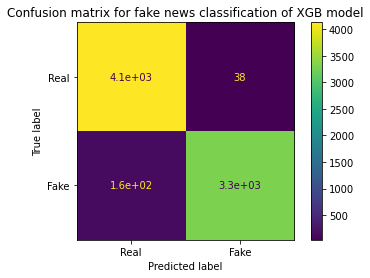

In [32]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictionsXGB), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of XGB model")

In [33]:
xgb_report = pd.DataFrame({"Model": ["XGBoost"],
                          "Accuracy": [accuracyXGB],
                          "ROC": [rocXGB],
                          "Inference (s)": [inferenceXGB]})

### Logistic Regression

In [34]:
predictionsLR, accuracyLR, rocLR, inferenceLR = train_and_predict(LogisticRegression(), roberta_train, y_train, roberta_test, y_test)

Accuracy: 0.80
Roc_auc score: 0.79
Inference time for a batch of 32 entries is: 0.0s
              precision    recall  f1-score   support

           0       0.80      0.84      0.82      4166
           1       0.80      0.75      0.77      3488

    accuracy                           0.80      7654
   macro avg       0.80      0.79      0.80      7654
weighted avg       0.80      0.80      0.80      7654



Text(0.5, 1.0, 'Confusion matrix for fake news classification of LogReg model')

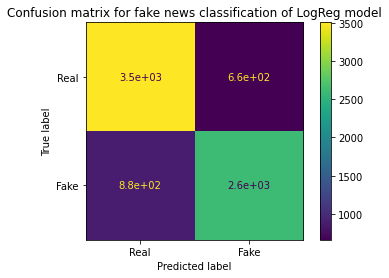

In [35]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictionsLR), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of LogReg model")

In [36]:
logreg_report = pd.DataFrame({"Model": ["LogReg"],
                          "Accuracy": [accuracyLR],
                          "ROC": [rocLR],
                          "Inference (s)": [inferenceLR]})

### Gaussian Naive Bayes

In [37]:
predictionsNB, accuracyNB, rocNB, inferenceNB = train_and_predict(GaussianNB(), roberta_train, y_train, roberta_test, y_test)

Accuracy: 0.77
Roc_auc score: 0.77
Inference time for a batch of 32 entries is: 0.0002s
              precision    recall  f1-score   support

           0       0.83      0.73      0.77      4166
           1       0.71      0.82      0.76      3488

    accuracy                           0.77      7654
   macro avg       0.77      0.77      0.77      7654
weighted avg       0.78      0.77      0.77      7654



Text(0.5, 1.0, 'Confusion matrix for fake news classification of GaussianNB model')

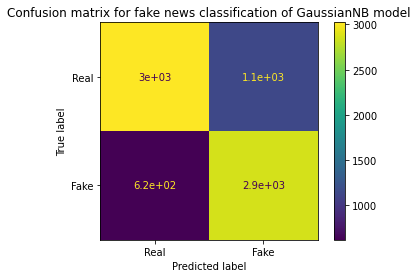

In [38]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictionsNB), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of GaussianNB model")

In [39]:
nb_report = pd.DataFrame({"Model": ["NaiveBayes"],
                          "Accuracy": [accuracyNB],
                          "ROC": [rocNB],
                          "Inference (s)": [inferenceNB]})

### CatBoostClassifier

In [40]:
predictionsCB, accuracyCB, rocCB, inferenceCB = train_and_predict(CatBoostClassifier(eval_metric = 'Accuracy', iterations = 2000, learning_rate = 0.2, verbose = 0), roberta_train, y_train, roberta_test, y_test)

Accuracy: 0.97
Roc_auc score: 0.97
Inference time for a batch of 32 entries is: 0.0059s
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      4166
           1       0.99      0.95      0.97      3488

    accuracy                           0.97      7654
   macro avg       0.98      0.97      0.97      7654
weighted avg       0.97      0.97      0.97      7654



Text(0.5, 1.0, 'Confusion matrix for fake news classification of CatBoostClassifier model')

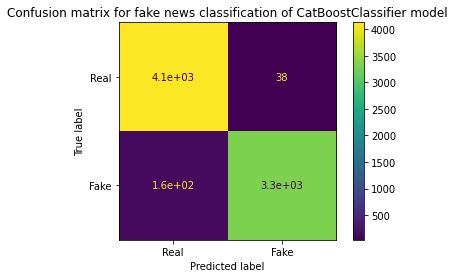

In [41]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predictionsCB), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of CatBoostClassifier model")

In [42]:
cb_report = pd.DataFrame({"Model": ["CatBoostClassifier"],
                          "Accuracy": [accuracyCB],
                          "ROC": [rocCB],
                          "Inference (s)": [inferenceCB]})

# Deep Learning

Next part of the project is to use deep learning. I will tackle this task with the help of pytorch lightning. First I will create FakeTexts class (which inherits from Dataset). This class will help me to process my data before passing it to the deep learning model. 

My deep learning model will be RobertaForSequenceClassification. The RoBERTa model was proposed in RoBERTa: A Robustly Optimized BERT Pretraining Approach by Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov. It is based on Google’s BERT model released in 2018.

For logging I will use Neptune.ai logging platform.

In [43]:
x_train_dl, x_test_dl, y_train_dl, y_test_dl = train_test_split(news['text'], news['fake'], test_size=0.1, random_state=1, shuffle=True)

x_train_dl, x_val_dl, y_train_dl, y_val_dl = train_test_split(x_train_dl, y_train_dl, test_size=0.1, random_state=1, shuffle=True) 

len(x_train_dl), len(x_val_dl), len(y_train_dl), len(y_val_dl), len(x_test_dl), len(y_test_dl)

(30998, 3445, 30998, 3445, 3827, 3827)

In [44]:
train_df = pd.concat([x_train_dl, y_train_dl], axis=1).reset_index(drop=True)

In [45]:
val_df = pd.concat([x_val_dl, y_val_dl], axis=1).reset_index(drop=True)

In [46]:
class FakeTexts(Dataset):


    def __init__(self, df: pd.DataFrame, max_sequence_length: int = 256):
        self.tokenizer = transformers.RobertaTokenizer.from_pretrained("roberta-base", do_lower_case=True)
        self.df = df
        self.max_sequence_length = max_sequence_length
        

    def __len__(self) -> int:
        return len(self.df)


    def __getitem__(self, idx) -> dict:
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
        label = self.df.loc[idx, 'fake']

        encoded = self.tokenizer.encode_plus(
            text = self.df.loc[idx, "text"],                      
            add_special_tokens = True, 
            max_length = self.max_sequence_length,
            padding = 'max_length',
            return_attention_mask = True,
            pad_to_max_length = False,
            truncation = True,
            return_tensors = 'pt',
        )
        encoded = {k:v.squeeze(0) for k,v in encoded.items()}
        encoded['label'] = torch.tensor(label,  dtype=torch.int64)
        return encoded

In [47]:
class TextClassifier(pl.LightningModule):
    
    
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        config = transformers.RobertaConfig.from_pretrained("roberta-base", num_labels=1)
        self.model = transformers.RobertaForSequenceClassification.from_pretrained('roberta-base',  config=config)
        self.lr = 1e-3
        self.criterion = torch.nn.BCELoss()
        self.batch_size = 32
        self.base_grad(requires_grad = False)

        
    def base_grad(self, requires_grad: bool):
        for param in self.model.base_model.parameters():
            param.requires_grad = requires_grad


    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, labels: torch.Tensor = None):
        predictions = self.model(input_ids, attention_mask=attention_mask, return_dict=True)
        predictions = torch.sigmoid(predictions.logits).squeeze(1)
        if labels is not None:
            loss = self.criterion(predictions.type(torch.FloatTensor), labels.type(torch.FloatTensor))
            return loss, predictions
        else:
            return predictions

    
    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["label"]
        loss, predictions = self(input_ids, attention_mask, labels)
        
        self.log("train_loss", loss, prog_bar=True, logger=True, on_epoch=True)
        return {"loss": loss, "predictions": predictions, "labels": labels}

    
    def validation_step(self, val_batch: dict, batch_idx):
        input_ids = val_batch["input_ids"]
        attention_mask = val_batch["attention_mask"]
        labels = val_batch["label"]
        loss, predictions = self(input_ids, attention_mask, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True, on_epoch=True)
        return {"loss": loss, "predictions": predictions, "labels": labels}

    
    def configure_optimizers(self):
        """
        This method is required by the framework so setup optimizer for the model
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer
    
    
    def train_dataloader(self):
        return DataLoader(FakeTexts(train_df), batch_size=self.batch_size, shuffle=True, num_workers=8)
    
    
    def val_dataloader(self):
        return DataLoader(FakeTexts(val_df), batch_size=self.batch_size, shuffle=False, num_workers=8)
  
    
    def training_epoch_end(self, outputs: dict) -> None:
        """
        Contains the outputs of the training_step, collected for all batches over the epoch.
        Tracks the progress of the entire epoch by calculating average loss.
        """
        avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
        print(f"Training loss is {avg_loss} for this epoch")
        neptune_logger["train_loss"].log(avg_loss)


    def validation_epoch_end(self, validation_step_outputs: dict) -> None:
        """
        Contains the outputs of the validation_step, collected for all batches over the epoch.
        Tracks the progress of the entire epoch by calculating average loss.
        """
        avg_val_loss = torch.stack(
            [output["loss"] for output in validation_step_outputs]
        ).mean()
        print(f"Validation loss is {avg_val_loss} for this epoch")
        neptune_logger["val_loss"].log(avg_val_loss)


In [ ]:
import neptune.new as neptune

neptune_logger = neptune.init(project='tiskutis/FakeTexts',
                   api_token='')

In [49]:
def train(model, epochs, lr):
    model.lr = lr
    early_stopping_callback = EarlyStopping(
        monitor="val_loss", patience=2
        ) 
    trainer = pl.Trainer(max_epochs=epochs, 
                         gpus=torch.cuda.device_count())
    trainer.fit(model)
    
    return trainer


def train_and_save(train_epochs: int = 3, finetune_epochs: int = 6, train_lr: float = 1e-3, finetune_lr: float = 1e-5):
    
    model = TextClassifier() 
    print("=" * 25, f"Training - ", "=" * 25)
    train(model, epochs=train_epochs, lr=train_lr)
    
    print("=" * 25, f"Fine-tuning - ", "=" * 25)
    model.base_grad(True)
    trainer = train(model, epochs=finetune_epochs, lr=finetune_lr)
    
    model_filename = f'roberta44.ckpt'
    trainer.save_checkpoint(model_filename)

Train and validation losses:

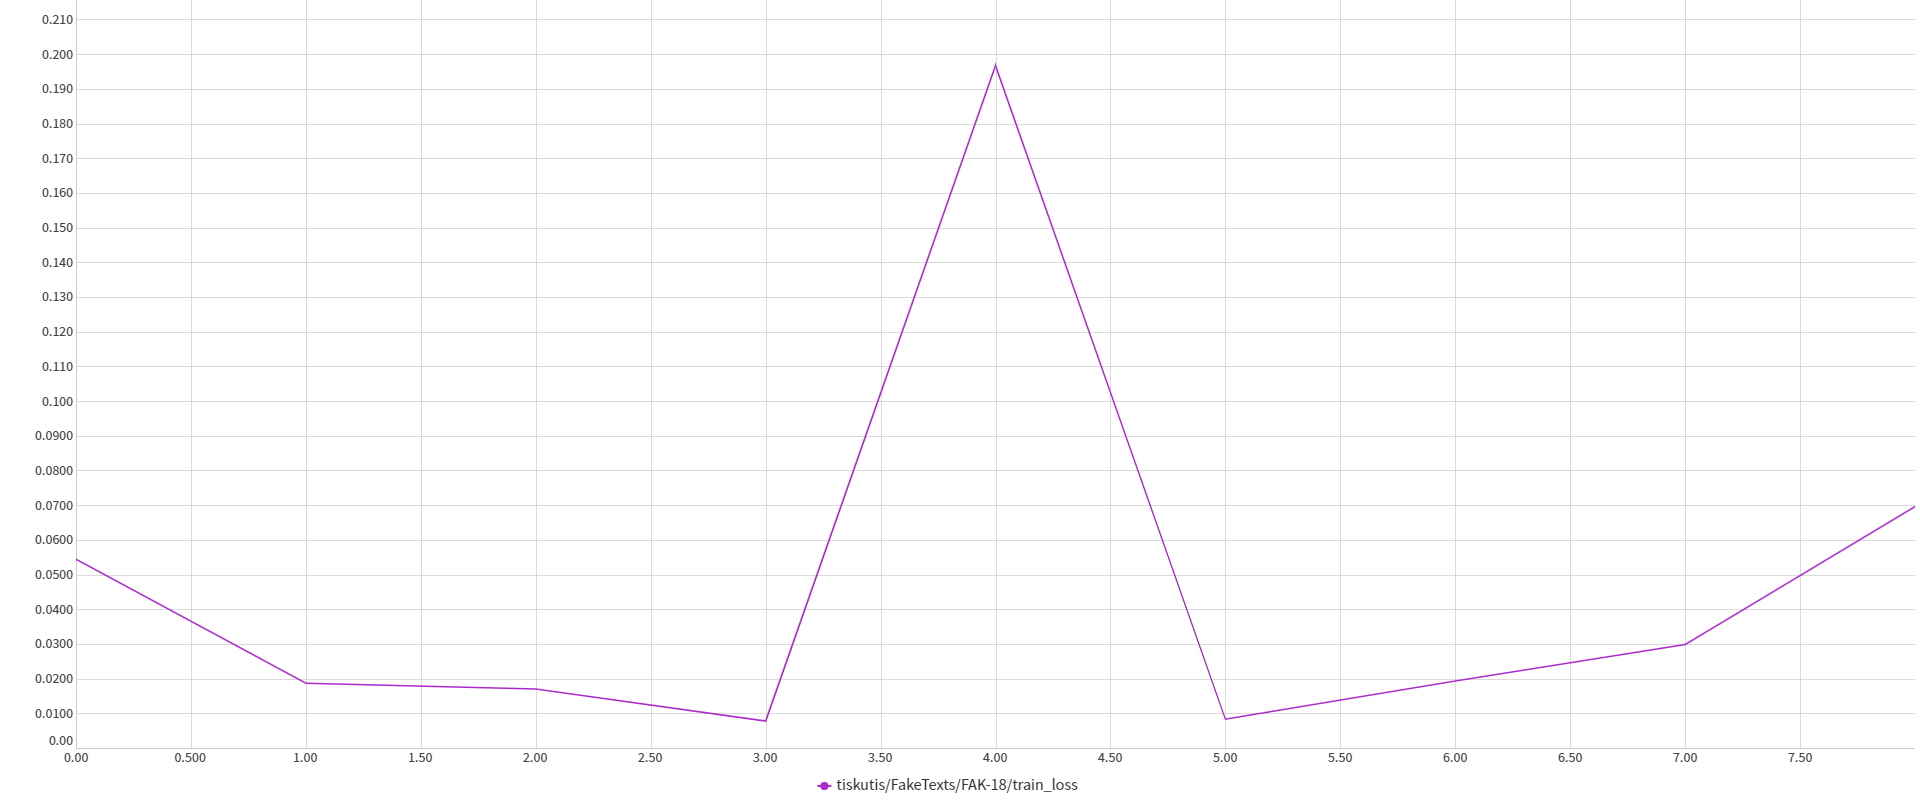

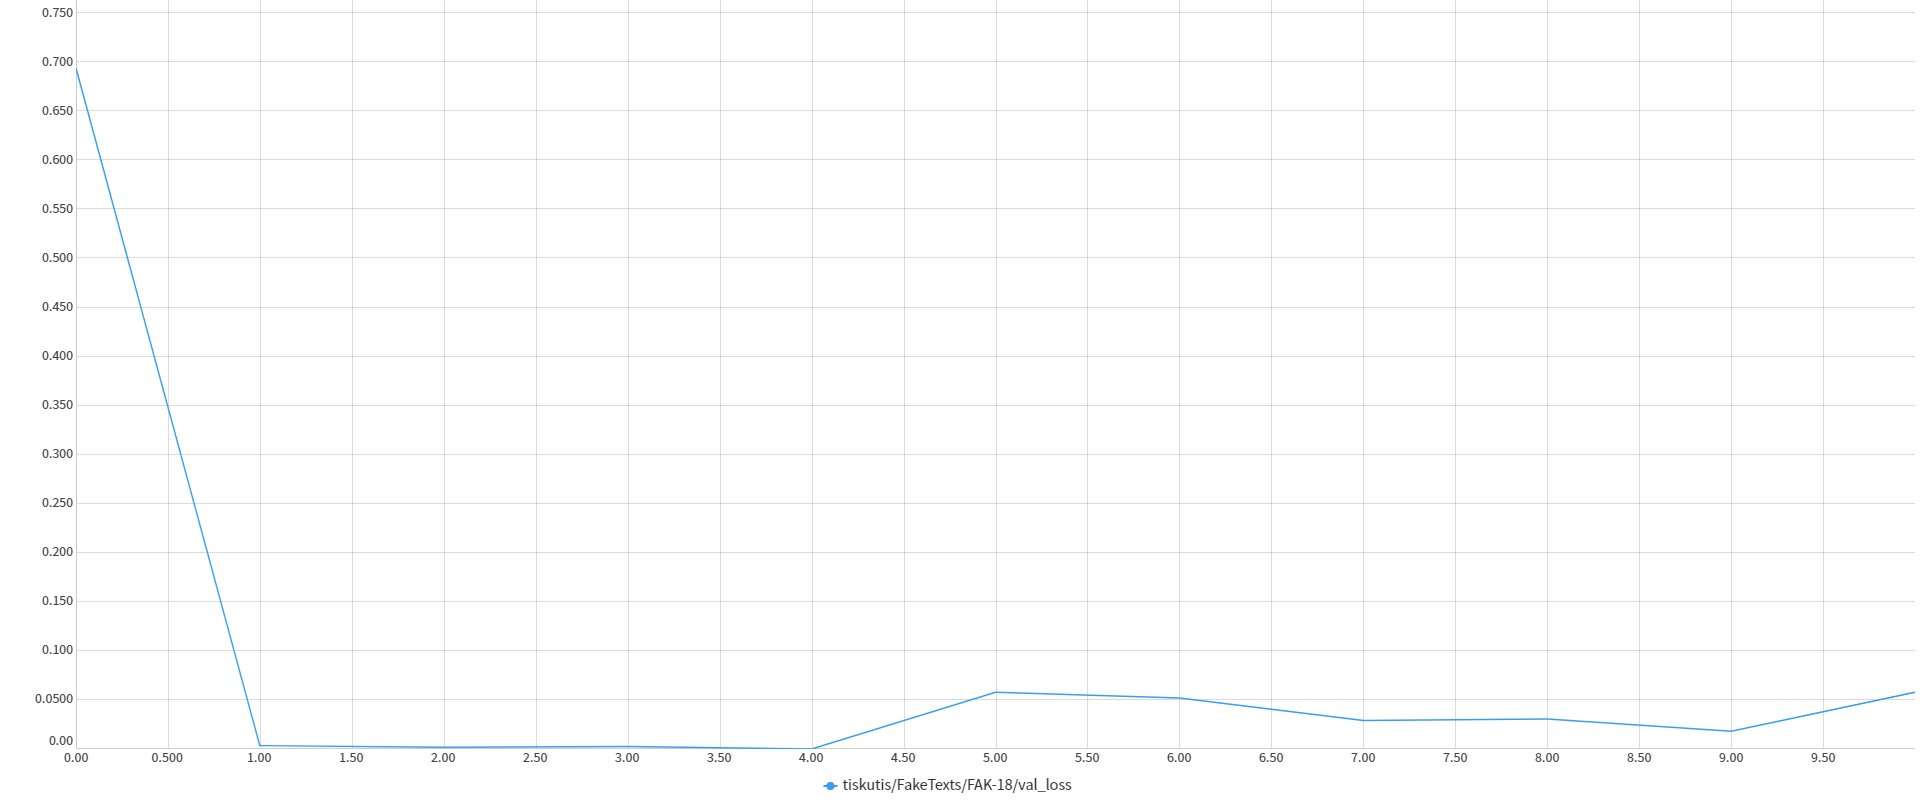

In [50]:
roberta44_checkpoint = train_and_save()

Model was trained before on Kaggle platform and I uploaded it into my google drive account. Here I will fetch it from gdrive and use it for evaluation.

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = TextClassifier().load_from_checkpoint("/content/drive/MyDrive/44/roberta44.ckpt")
model.eval().to(device)

In [52]:
test_df = pd.concat([x_test_dl, y_test_dl], axis=1).reset_index(drop=True)

In [ ]:
test_dataset = FakeTexts(test_df)
loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=8
)

In [54]:
y_pred = []
y_true = []
inference_time = []

with torch.no_grad():
    for i, batch in enumerate(loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        start = time.time()
        predictions = model(batch["input_ids"], batch["attention_mask"])
        end = time.time()
        y_pred.append(predictions)
        y_true.append(batch["label"])
        inference_time.append(end-start)

In [55]:
predictions = torch.cat(y_pred).int().cpu()
labels = torch.cat(y_true).int().cpu()

In [56]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2122
           1       1.00      1.00      1.00      1705

    accuracy                           1.00      3827
   macro avg       1.00      1.00      1.00      3827
weighted avg       1.00      1.00      1.00      3827



Text(0.5, 1.0, 'Confusion matrix for fake news classification')

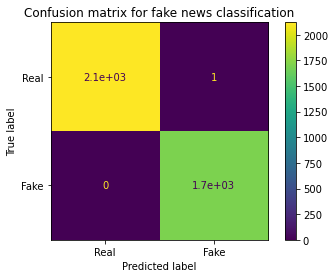

In [57]:
disp = ConfusionMatrixDisplay(confusion_matrix(labels, predictions), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification")

In [58]:
roberta_score = accuracy_score(labels, predictions)
roberta_roc = roc_auc_score(labels, predictions)
roberta_inference = sum(inference_time)/len(inference_time)
print("The accuracy of heuristic model is: %0.2f" %roberta_score)
print("The roc_auc score of heuristic model is: %0.2f" %roberta_roc)
print(f"Inference time for a batch of 32 entries is: {roberta_inference}s")

The accuracy of heuristic model is: 1.00
The roc_auc score of heuristic model is: 1.00
Inference time for a batch of 32 entries is: 25.544225245714188s


The results are perfect - there are almost no misclassified examples. Seems that deep learning approach is a bit of an overkill - similar success had been achieved with decision trees. 

In [59]:
cb_report = pd.DataFrame({"Model": ["Roberta"],
                          "Accuracy": [roberta_score],
                          "ROC": [roberta_roc],
                          "Inference (s)": [roberta_inference]})

# ML results

All of the results of previous models are provided here. Best performing models are those of decision trees - XGBoost and CatBoost - both of them have accuracy and ROC of around 0.97. LogisticRegression and NaiveBayes perform worse - 0.79 and 0.76 (accuracy) and 0.79 and 0.76 (ROC) respectively. 

In [60]:
pd.concat([heur_report, xgb_report, logreg_report, nb_report, cb_report]).round(5)

,Model,Accuracy,ROC,Inference (s)
0,Heuristic,0.99321,0.99271,0.00050
0,XGBoost,0.97348,0.97179,0.00240
0,LogReg,0.79867,0.79454,0.00000
0,NaiveBayes,0.76953,0.77380,0.00020
0,Roberta,0.99974,0.99976,25.54423


# Lime Explanations

Lime is able to explain any black box classifier with two or more classes. All it requires is that the classifier implements a function that takes in raw text or a numpy array and outputs a probability for each class. Explanations here are done using this tutorial: https://marcotcr.github.io/lime/tutorials/Lime%20-%20basic%20usage%2C%20two%20class%20case.html

Since lime has built-in support for sklearn, I had to create a pipeline with preprocessor and model. Pipe's output is then fed to lime explainer.
Here I will be testing previously trained XGBoost classifier. I will write custom preprocessor, which will tokenize raw text just like before, but now this preprocessor will be part of the pipeline together with XGBoost model.

In [61]:
class RobertaPreprocessor(BaseEstimator, TransformerMixin):
  def __init__(self):
    return None

  def fit(self, X, y=None):
    return self

  def transform(self, X, y=None):
    roberta_tokenizer = transformers.RobertaTokenizer.from_pretrained('roberta-base-openai-detector')
    features = []
    for doc in tqdm.tqdm(X, desc='converting documents to features'):
        tokens = roberta_tokenizer.tokenize(doc)
        ids = roberta_tokenizer.convert_tokens_to_ids(tokens)
        features.append(ids)
    features = sequence.pad_sequences(features, maxlen = 500)
    return features

In [ ]:
pipe = Pipeline(
    steps=[
           ("Preprocessor", RobertaPreprocessor()),
           ("model", xgb)
    ]
)

pipe.fit(X_train, y_train)

In [ ]:
predxgb = pipe.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix for fake news classification of XGB model')

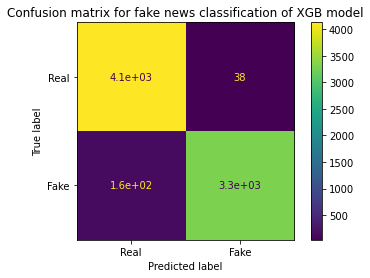

In [65]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, predxgb), display_labels=["Real", "Fake"])
disp.plot()
disp.ax_.set_title(f"Confusion matrix for fake news classification of XGB model")

We have 160 Fakes, classified as reals and 38 Reals, classified as fakes. I will collect their indexes into two lists and will take a look at several examples of each.

In [66]:
predicted_real_but_really_fake = [i for i, tuple_ in enumerate(zip(predxgb, y_test)) if tuple_[0] != tuple_[1] and tuple_[0] == 0]
predicted_fake_but_really_real = [i for i, tuple_ in enumerate(zip(predxgb, y_test)) if tuple_[0] != tuple_[1] and tuple_[0] == 1]

Sadly, google colab environment always timed out or disconnected during lime explainer run, so I had to run explainer in Kaggle. The results are presented below in picture format.

- Real news predicted as fake:

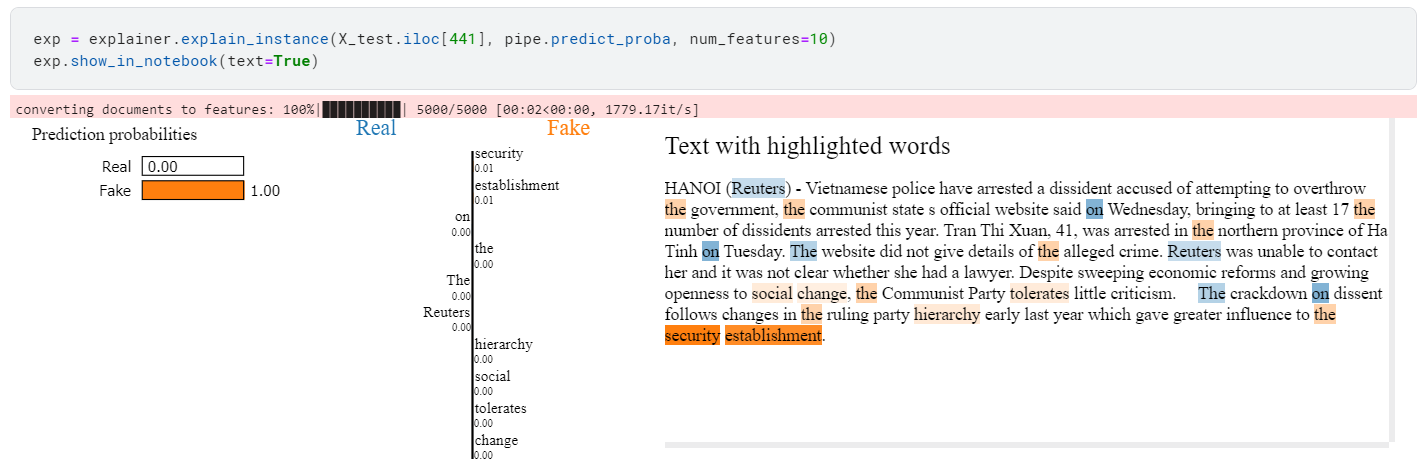

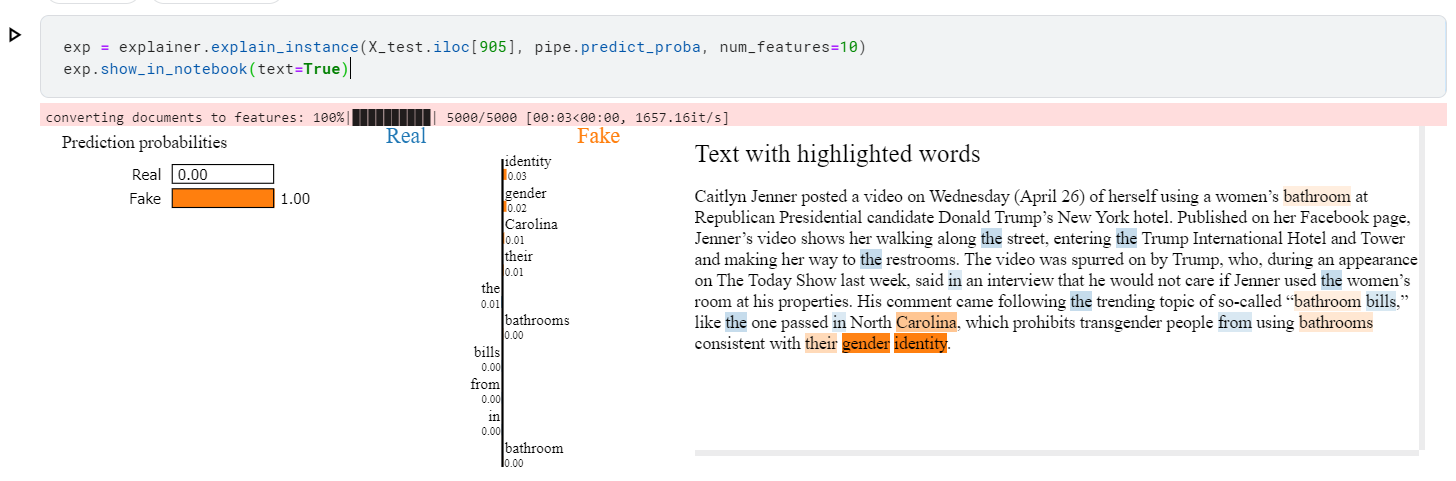

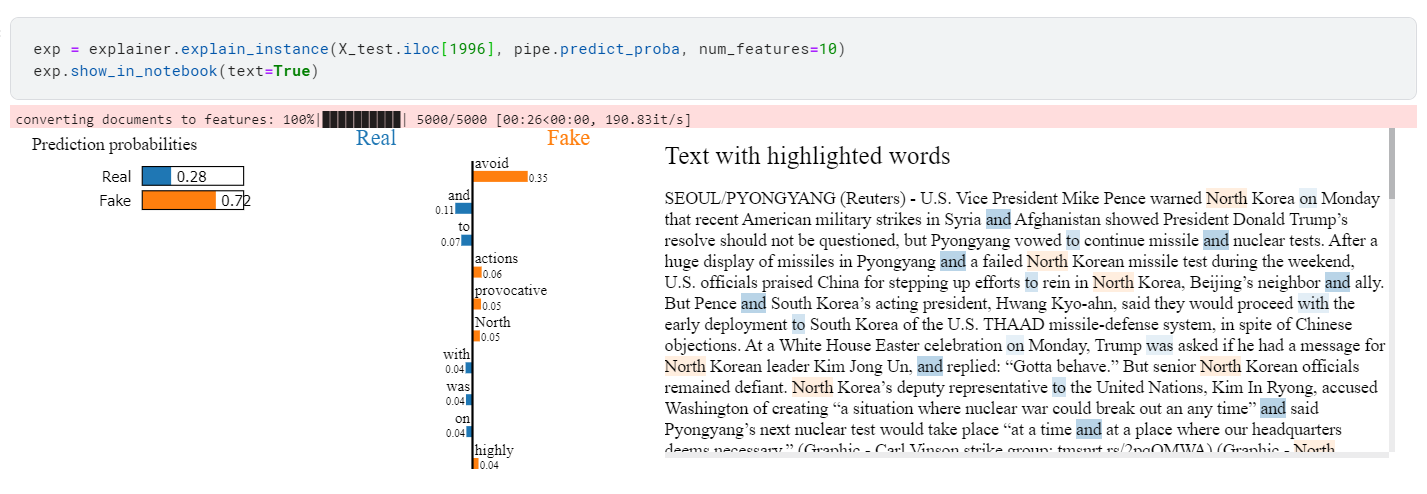

- Fake news predicted as real:

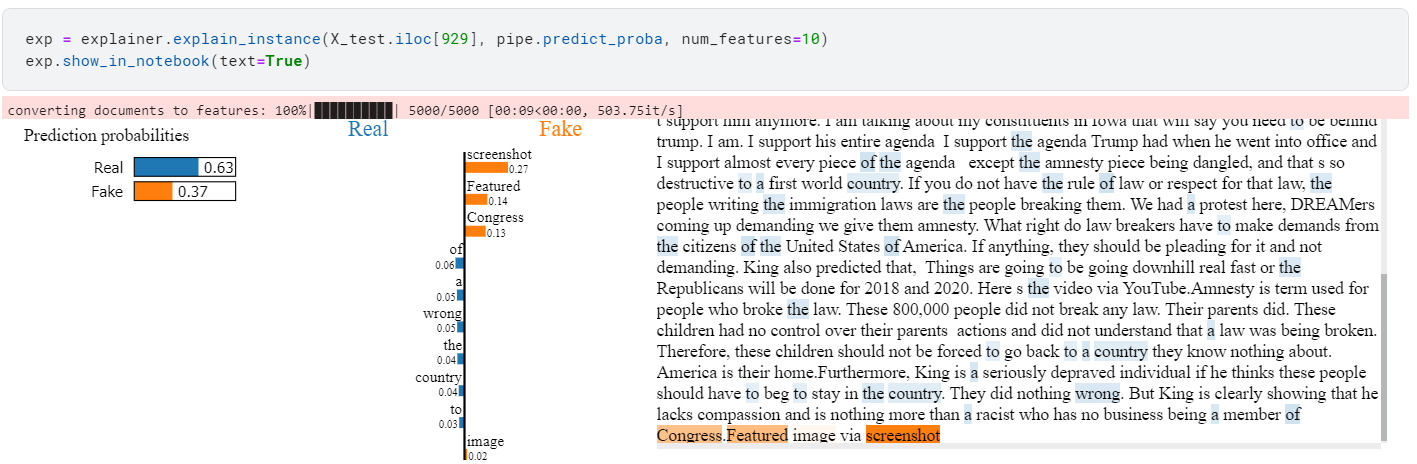

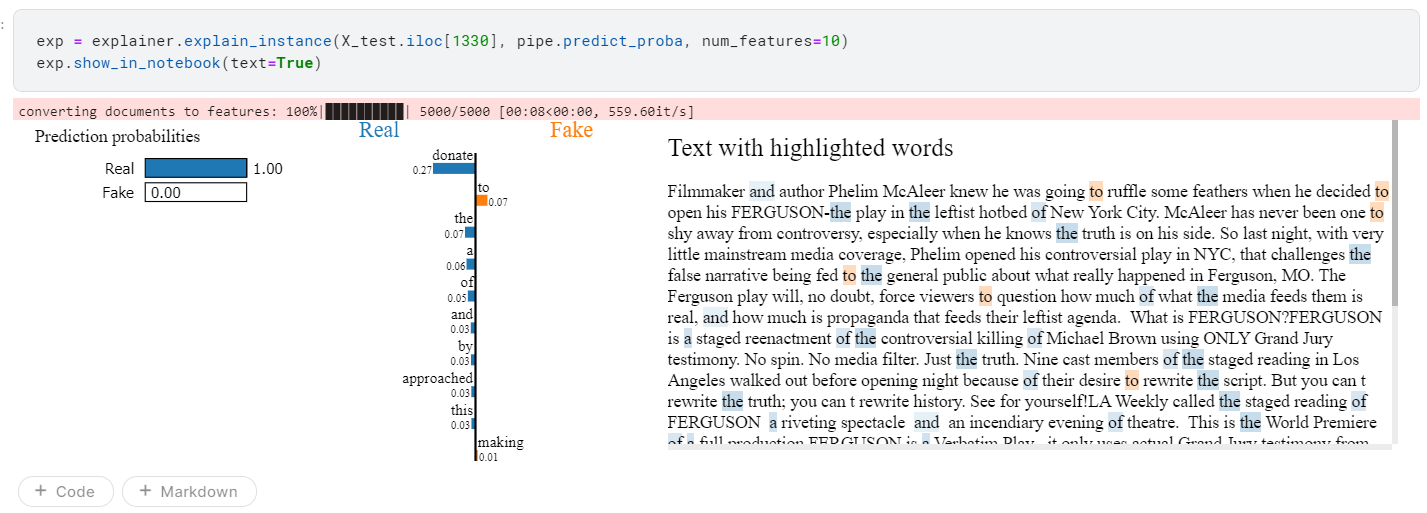

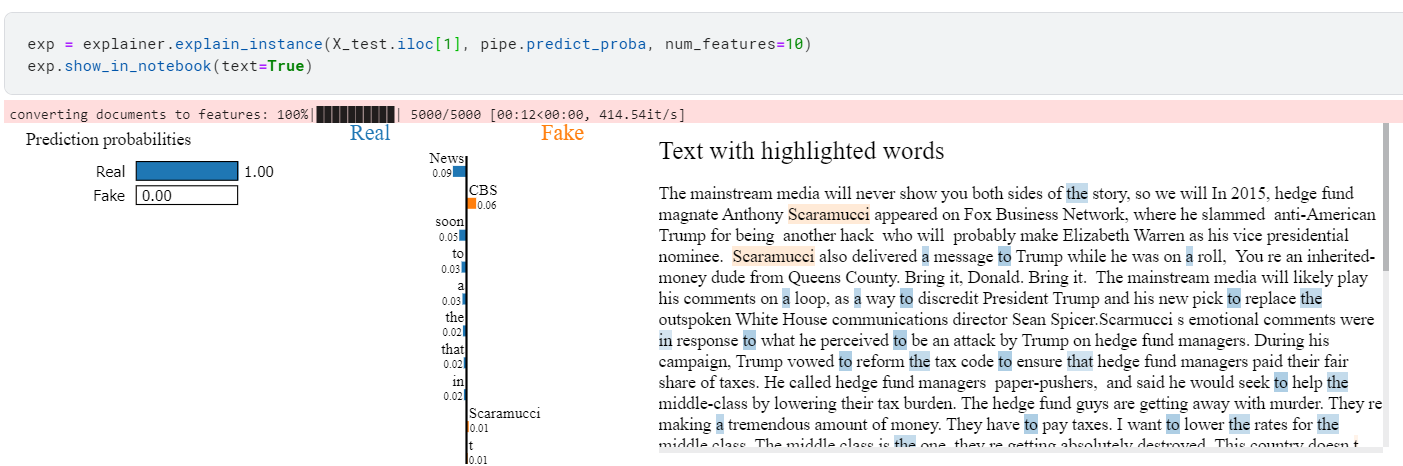

The dataset I had to work with is clearly biased - all real news are taken from Reuters news agency and fake news from different various sources. Heuristic model proved very accurate with defining rule being: if text has word 'reuters' in it - it is real news and fake otherwise. Although such classification method seems very silly - that is the feature of this specific dataset. For more complicated ML models I chose 4: two of them is decision trees-based (CatBoost and XGBoost) and other two - LogReg and GaussianNaiveBayes. Decision trees-based algorithms proved to be more accurate than LogReg and GaussianNaiveBayes. For deep learning part I chose to work with Roberta pretrained model, which had perfect classification scores - no surprise that deep learning algorithm caught the defining classification rule so well. 